In [16]:
import os
import pandas as pd
import pickle
import numpy as np

from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [61]:
class Training:
    def __init__(self):
        self.data_csv = pd.read_csv('genteng1.csv')
        self.label_encoders = {}
        self.model = LinearRegression()
        print("TRAIN HEAD", self.data_csv.head())
        print("SHAPE", self.data_csv.shape)

    def summaries_features(self, df):
        # tipe data
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary = summary.reset_index()

        # jumlah missing value
        summary['Missing'] = df.isnull().sum().values

        # jumlah unique value
        summary['Unique'] = df.nunique().values
        return summary

    def preprocess_data(self):
        # Melakukan preprocessing pada kolom jenis dan pabrik
        self.data_csv['Jenis'] = self.data_csv['Jenis'].apply(lambda x: x.lower())
        self.data_csv['Pabrik'] = self.data_csv['Pabrik'].apply(lambda x: x.lower())

    def fuzzy_match(self, input_string, target_strings):
        scores = [fuzz.ratio(input_string, target) for target in target_strings]
        max_score = max(scores)
        max_index = scores.index(max_score)
        return target_strings[max_index]

    def encode_labels(self):
        # membagi label yang mengandung spasi mejadi kata terpisah
        self.data_csv['Jenis'] = self.data_csv['Jenis'].str.split()
        self.data_csv['Pabrik'] = self.data_csv['Pabrik'].str.split()

        # Mengonversi list menjadi string untuk label encoder
        self.data_csv['Jenis'] = self.data_csv['Jenis'].apply(lambda x: ' '.join(map(str, x)))
        self.data_csv['Pabrik'] = self.data_csv['Pabrik'].apply(lambda x: ' '.join(map(str, x)))

        # membuat label encoder untuk kolom yang memerlukan encoding
        self.label_encoders['Jenis'] = LabelEncoder()
        self.label_encoders['Pabrik'] = LabelEncoder()

        # mengubah data menjadi multi-label binarizer
        self.mlb = MultiLabelBinarizer()

        # menerapkan transformasi label encoder dan multi-label binarizer
        # pada data
        for column, le in self.label_encoders.items():
            self.data_csv[column] = le.fit_transform(self.data_csv[column])
        # self.data_csv = self.mlb.fit_transform(
        #     self.data_csv[['Jenis','Pabrik']]
        # )

    def transform_data(self):
        # menggabungkan fitur yang sudah diencode
        transformed = pd.concat(
            [self.data_csv['Jenis'],
            self.data_csv['Pabrik']],
            axis=1
        )
        # mengubah data menjadi dataframe dengan fitur yang sesuai
        # transformed = pd.DataFrame(
        #     self.data_csv,
        #     columns=self.mlb.classes_
        # )
        return transformed

    def train_model(self):
        # mengambil fitur dan target
        X = self.transform_data()
        y = self.data_csv['Harga']

        # melakukan pelatihan
        self.model.fit(X, y)

    def save_model(self):
        # menyimpan model file
        model_path = 'model_regression.pk1'
        with open(model_path, 'wb') as file:
            pickle.dump(self.model, file)

        # menyimpan label encoder
        encoder_path = 'model_label.pk1'
        with open(encoder_path, 'wb') as file:
            pickle.dump(self.label_encoders, file)

        print("Model and label encoders have been saved.")

        # mlb_file = os.path.join(media, 'mlb_file.sav')
        # with open(mlb_file, 'wb') as file:
        #     pickle.dump(self.mlb_file, file)

    def the_datas(self):
        summary = self.summaries_features(self.data_csv)
        print("SUMMARY", summary)
        self.encode_labels()
        self.transform_data()
        self.train_model()
        self.save_model()
        return summary


In [62]:
train = Training()
train.the_datas()

TRAIN HEAD                        Jenis                     Pabrik  Harga
0            Morando Natural  PT Bukit Karya Jatiwangi    2800
1  Morando Glazur Transparan  PT Bukit Karya Jatiwangi    3800
2       Morando Glazur Brown  PT Bukit Karya Jatiwangi    3800
3              Turbo Natural  PT Bukit Karya Jatiwangi    2500
4    Turbo Glazur Transparan  PT Bukit Karya Jatiwangi    3500
SHAPE (153, 3)
SUMMARY     index  dtypes  Missing  Unique
0   Jenis  object        0      69
1  Pabrik  object        0       5
2   Harga   int64        0      29
Model and label encoders have been saved.


,index,dtypes,Missing,Unique
0,Jenis,object,0,69
1,Pabrik,object,0,5
2,Harga,int64,0,29


In [63]:
y_pred = train.data_csv
print(y_pred)

     Jenis  Pabrik  Harga
0       20       1   2800
1       19       1   3800
2       15       1   3800
3       68       1   2500
4       67       1   3500
..     ...     ...    ...
148     55       3   3200
149     54       3   3200
150      8       3   4500
151      7       3   6000
152      6       3   6000

[153 rows x 3 columns]


array([[<Axes: title={'center': 'Jenis'}>,
        <Axes: title={'center': 'Pabrik'}>],
       [<Axes: title={'center': 'Harga'}>, <Axes: >]], dtype=object)

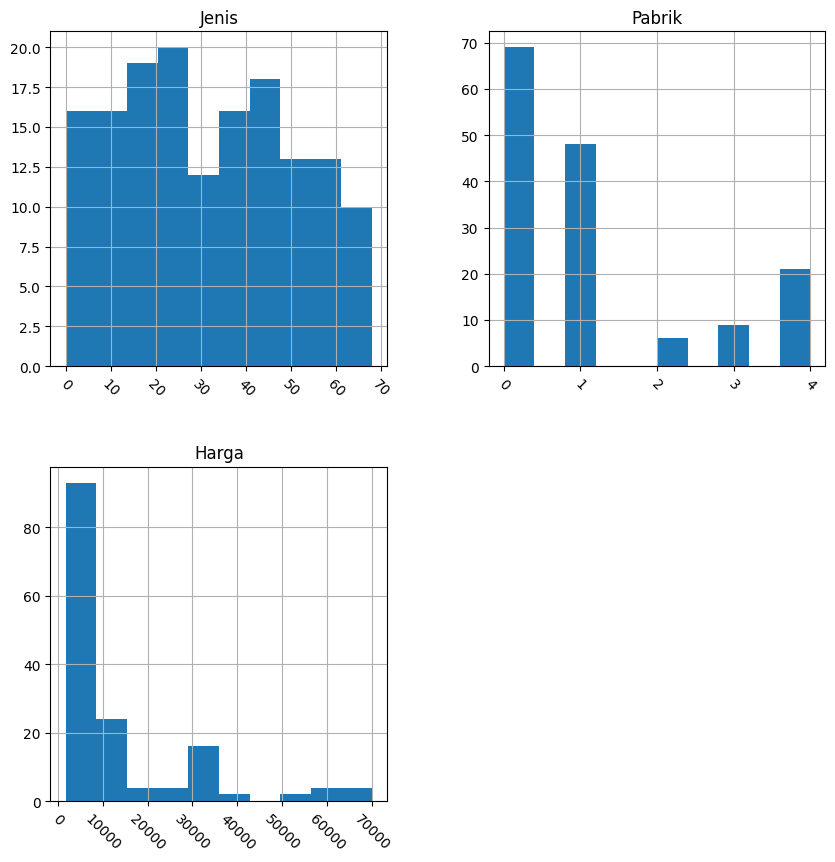

In [51]:
y_pred.hist(figsize=(10,10), xrot=-45)

In [52]:
# missing value
y_pred.select_dtypes(exclude=['object']).isnull().sum()

Jenis     0
Pabrik    0
Harga     0
dtype: int64

<Axes: >

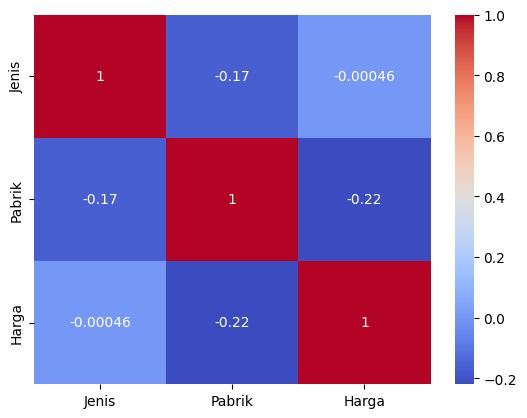

In [64]:
corr_matrix = y_pred.corr()
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [59]:
# Prediksi

class Prediction:
    def __init__(self):
        self.model_file = 'model_regression.pk1'
        self.label_file = 'model_label.pk1'
        self.model = None
        self.label_encoders = {}

    def load_model(self):
        with open(self.model_file, 'rb') as file:
            self.model = pickle.load(file)

        with open(self.label_file, 'rb') as file:
            self.label_encoders = pickle.load(file)

    def transform_input(self, input_data):
        #mengubah input menjadi angka
        transformed_input = pd.DataFrame(input_data, index=[0])

        # membagi label yang mengandung spasi
        transformed_input['Jenis'] = transformed_input['Jenis'].str.split()
        transformed_input['Pabrik'] = transformed_input['Pabrik'].str.split()

        transformed_input['Jenis'] = transformed_input['Jenis'].apply(lambda x: ' '.join(map(str, x)))
        transformed_input['Pabrik'] = transformed_input['Pabrik'].apply(lambda x: ' '.join(map(str, x)))

        # konversi list menjadi string
        for column, le in self.label_encoders.items():
            # Mengabaikan label yang belum pernah dilihat pada saat pelatihan
            transformed_input[column] = transformed_input[column].apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
        return transformed_input

    def predict_price(self, jenis, pabrik):
        self.load_model()
        print("LABEL ENCODER", self.label_encoders, self.model)

        print("Coef", self.model.coef_)
        print('Intercept', self.model.intercept_)
        # mengubah input jadi angkat
        transform_input = self.transform_input(
            {
                'Jenis': jenis,
                'Pabrik': pabrik
            }
        )

        prediksi = self.model.predict(transform_input)
        return round(prediksi[0])

In [68]:
prediksi = Prediction()
prediksi = prediksi.predict_price('merando','jatiwangi')

print(f'Prediksi', prediksi)

LABEL ENCODER {'Jenis': LabelEncoder(), 'Pabrik': LabelEncoder()} LinearRegression()
Coef [  -32.67597103 -2594.92265421]
Intercept 17803.023726794894
Prediksi 20431
